# Coronavirus testing locations in California

### Load python tools

In [1]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### Import testing locations from state map, which uses to Esri API endpoints

In [2]:
# map front end: https://www.arcgis.com/apps/Nearby/index.html?appid=43118dc0d5d348d8ab20a81967a15401
# community: https://services.arcgis.com/8ZpVMShClf8U8dae/arcgis/rest/services/TestingLocations_public2/FeatureServer/0
# state: https://services.arcgis.com/BLN4oKB0N1YSgvY8/arcgis/rest/services/State_Test_Sites/FeatureServer/0

### Read state-sponsored locations

In [3]:
state = gpd.read_file('/Users/mhustiles/data/github/AGStoShapefile/\
backupdir/State_Test_Sites/State_Test_Sites_1588871784588.geojson')

In [4]:
state.columns = state.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [5]:
state.iloc[0]

objectid                                                       3
globalid                    0a3c99f8-4e79-41ee-a307-94d2b22ca10f
county                                                     Butte
address                                             2357 Fair St
city                                                       Chico
zipcode                                                    95928
hoursofoperation                                       0700-1900
operator                                              OPTUMServe
sitename                                            OPTUMServe 1
website                            https://lhi.care/covidtesting
daysofoperation                       Mon, Tues, Wed, Thurs, Fri
publicphone                                       (888) 634-1123
geometry            POINT (-121.8130604997285 39.71829599981998)
Name: 0, dtype: object

### Read broader list of community testing locations

In [6]:
community_all = gpd.read_file('/Users/mhustiles/data/github/AGStoShapefile/backupdir/\
testing_sites/testing_sites_1588869347830.geojson')

In [7]:
community_all.columns = community_all.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

### Select on the California locations from Esri's list

In [8]:
community = pd.DataFrame(community_all[community_all['state'] == "CA"])

In [9]:
len(community)

800

In [10]:
community[community['name'] == 'Quest Diagnostics - Reservation Road']

objectid facilityid                                  name  \
2399     10365       None  Quest Diagnostics - Reservation Road   

                                  fulladdr municipality             agency  \
2399  294 Reservation Rd, Marina, CA 93933       Marina  Quest Diagnostics   

     agencytype        phone  \
2399    Private  866-MYQUEST   

                                              agencyurl operhours  \
2399  http://patient.questdiagnostics.com/covid-test...      None   

                                               comments  \
2399  With QuestDirect, an individual can request th...   

                                           instructions  numvehicles  \
2399  After purchasing the service online, an indivi...          NaN   

      testcapacity             status  creationdate       editdate  \
2399           NaN  Scheduled to Open  1.588537e+12  1588536592324   

     drive_through appt_only referral_required services_offered_onsite  \
2399            No       Yes               Yes            testing only   

     call_first virtual_screening  \
2399         No                No   

                                        health_dept_url state  \
2399  https://www.cdph.ca.gov/Programs/CID/DCDC/Page...    CA   

                                  globalid          data_source    county  \
2399  60ca4227-ccf8-4723-a9ed-2935c6aa89cb  [CAC] Quest website  Monterey   

     red_flag vol_note public_form  start_date  end_date type_of_test  \
2399       no     None          no         NaN       NaN     antibody   

     test_processing fine_print                     geometry  
2399     offsite lab         no  POINT (-121.79312 36.68436)

In [11]:
community.iloc[500]

objectid                                                               10365
facilityid                                                              None
name                                    Quest Diagnostics - Reservation Road
fulladdr                                294 Reservation Rd, Marina, CA 93933
municipality                                                          Marina
agency                                                     Quest Diagnostics
agencytype                                                           Private
phone                                                            866-MYQUEST
agencyurl                  http://patient.questdiagnostics.com/covid-test...
operhours                                                               None
comments                   With QuestDirect, an individual can request th...
instructions               After purchasing the service online, an indivi...
numvehicles                                                              NaN

### What share of these locations off molecular vs. antibody testing? 

In [12]:
(community.type_of_test.value_counts('normalize')*100).round(2).astype(str) + '%'

antibody     53.75%
molecular    43.12%
both          1.88%
Both          1.25%
Name: type_of_test, dtype: object

In [13]:
community.type_of_test.value_counts()

antibody     430
molecular    345
both          15
Both          10
Name: type_of_test, dtype: int64

### What share of these locations are public vs. private? 

In [14]:
(community.agencytype.value_counts('normalize')*100).round(2).astype(str) + '%'

Private        78.34%
County          9.38%
Non Profit      3.45%
Municipal       1.79%
VA              1.66%
School          1.38%
Other           1.38%
State            1.1%
Regional        0.83%
Clinic          0.28%
Urgent Care     0.14%
Federal         0.14%
Tribal          0.14%
Name: agencytype, dtype: object

### What share of them are Quest versus other types of facilities?

In [15]:
(community.agency.value_counts('normalize')*100).round(2).astype(str) + '%'

Quest Diagnostics                                    59.78%
LA County                                             4.61%
UCLA Health                                           2.65%
Family Health Centers of San Diego                    2.51%
MedPost Urgent Care                                   2.37%
Exer Urgent Care                                      1.82%
Ventura County Public Health                          1.68%
OptumServe & State of CA                              1.68%
One Medical                                           1.26%
Perlman Clinic                                        1.12%
Accelerated Urgent Care                               0.98%
Project Baseline by Verily                            0.98%
Sharp Rees-Stealy                                     0.98%
Sutter Health                                         0.84%
Providence                                            0.84%
Carbon Health                                         0.84%
City and County of San Francisco        

---

### CA county geography

In [16]:
county_geo = gpd.read_file('input/ca-counties.geojson')

In [17]:
la_county_geo = gpd.read_file('input/lacountyboundary.geojson')

In [18]:
county_geo.crs = {'init': "epsg:4326"}

In [19]:
county_geo.columns = county_geo.columns.str.lower()

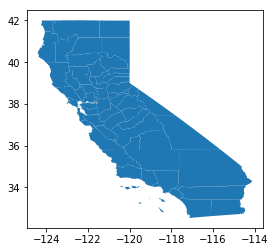

In [20]:
county_geo.plot()

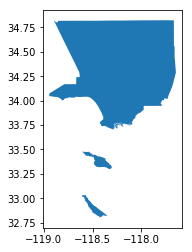

In [21]:
la_county_geo.plot()

### LA County communities

In [22]:
la_communities = gpd.read_file('input/lac_cities_no_islands.shp')

In [23]:
la_communities.columns = la_communities.columns.str.lower()

In [24]:
la_communities.crs = {'init': "epsg:4326"}

In [25]:
county_geo.crs = {'init': "epsg:4326"}

In [26]:
county_geo.columns = county_geo.columns.str.lower()

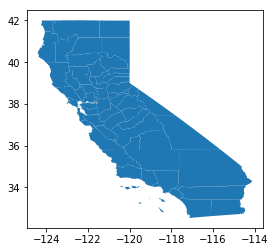

In [27]:
county_geo.plot()

---

### Merge with other dataframes

In [28]:
# counties_testing = gpd.sjoin(testing_locations_geo, county_geo, how="inner", op='intersects')

In [29]:
# counties_la_testing = gpd.sjoin(testing_locations_geo, la_county_geo, how="inner", op='intersects')

In [30]:
# cities_la_testing = gpd.sjoin(testing_locations_geo, la_communities, how="inner", op='intersects')

In [31]:
# counties_testing_counts = counties_testing.groupby(['name']).agg('size').reset_index(name='sites')

In [32]:
# cities_la_testing_counts = cities_la_testing.groupby(['city_name']).agg('size').reset_index(name='sites')

In [33]:
# counties_testing_counts.sort_values(by='sites', ascending=False).head()

In [34]:
# counties_testing_counts.to_csv('output/counties_testing_counts.csv')

### Merge testing counts to county polygons

In [35]:
# county_geo_testing = county_geo.merge(counties_testing_counts, on='name', how='left')

In [36]:
# la_city_geo_testing = la_communities.merge(cities_la_testing_counts, on='city_name', how='left')

In [37]:
# la_city_geo_testing.head()

In [38]:
# county_geo_testing.to_file('output/county_geo_testing.geojson', driver='GeoJSON')

In [39]:
# counties_la_testing.to_file('output/county_la_testing.geojson', driver='GeoJSON')

---

### Eventually output to Mapbox

In [40]:
# !tippecanoe --generate-ids --force -r1 -pk -pf -o \
# output/testing_locations_geo.mbtiles \
# output/testing_locations_geo.geojson